<a href="https://colab.research.google.com/github/rasmibhattarai72/Disease-Prediction-in-maize-plant/blob/main/Copy_of_Corn_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import splitfolders

In [5]:
splitfolders.ratio('/content/drive/MyDrive/corn', output='output', seed=1337, ratio=(.8,.1, .1), group_prefix=None)

Copying files: 4364 files [01:34, 46.26 files/s] 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle
import cv2
import PIL
import pathlib
import tensorflow as tf

In [7]:
import easydict
args = easydict.EasyDict({
        "test": "/content/output/test",
        "train":"/content/output/train",
        "val" :"/content/output/val",
})

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [9]:
train_dataset = image_dataset_from_directory(args['train'],
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(args['test'], image_size=IMG_SIZE,
                                            label_mode='categorical'
                                            )
val_dataset = image_dataset_from_directory(args['val'],
                                           label_mode = 'categorical',
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE)
class_names = test_dataset.class_names
                                        

Found 3490 files belonging to 4 classes.
Found 438 files belonging to 4 classes.
Found 436 files belonging to 4 classes.


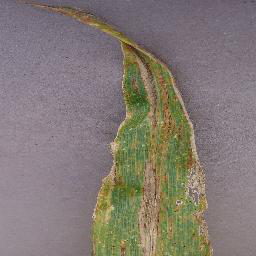

In [10]:
corn_1 = os.path.join('/content/output/train/Corn___Northern_Leaf_Blight/image (104).JPG')

PIL.Image.open(str(corn_1))


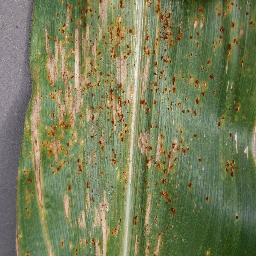

In [11]:
corn_2 = os.path.join('/content/output/train/Corn___Cercospora_leaf_spot Gray_leaf_spot/image (105).JPG')

PIL.Image.open(str(corn_2))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

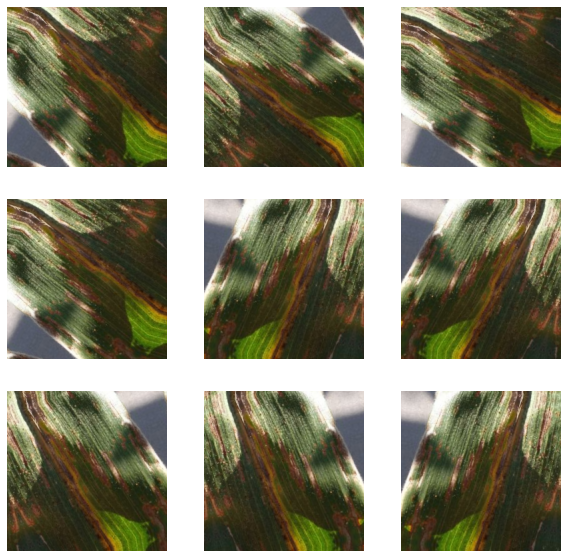

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 8, 8, 1280)


In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 120, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 120, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(4, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [22]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [25]:
len(model.trainable_variables)

2

In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset)

Epoch 1/15
 50/110 [============>.................] - ETA: 1:21 - loss: 1.3308 - accuracy: 0.4087

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 5
total_epochs =  15 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                          validation_data=val_dataset)

Epoch 1/20
110/110 [==============================] - 231s 2s/step - loss: 0.1624 - accuracy: 0.9361 - val_loss: 0.1460 - val_accuracy: 0.9312
Epoch 2/20
110/110 [==============================] - 235s 2s/step - loss: 0.1327 - accuracy: 0.9458 - val_loss: 0.2503 - val_accuracy: 0.8830
Epoch 3/20
110/110 [==============================] - 246s 2s/step - loss: 0.1103 - accuracy: 0.9585 - val_loss: 0.1138 - val_accuracy: 0.9495
Epoch 4/20
110/110 [==============================] - 245s 2s/step - loss: 0.1078 - accuracy: 0.9590 - val_loss: 0.1547 - val_accuracy: 0.9381
Epoch 5/20
110/110 [==============================] - 255s 2s/step - loss: 0.0943 - accuracy: 0.9648 - val_loss: 0.0987 - val_accuracy: 0.9656
Epoch 6/20
110/110 [==============================] - 285s 3s/step - loss: 0.0889 - accuracy: 0.9682 - val_loss: 0.1091 - val_accuracy: 0.9610
Epoch 7/20
110/110 [==============================] - 277s 3s/step - loss: 0.0812 - accuracy: 0.9682 - val_loss: 0.1028 - val_accuracy: 0.9633

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:
model.evaluate(test_dataset)

In [ ]:
from sklearn.externals import joblib
joblib.dump(model,'corndisease.pkl')